In [1]:
import time
import random
import numpy as np
import pandas as pd
import sys
import pickle
import h5py
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import learn2learn as l2l
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from functions.fftc import fft2c_new as fft2c
from functions.fftc import ifft2c_new as ifft2c
from functions.math import complex_abs, complex_mul, complex_conj
# The corase reconstruction is the rss of the zerofilled multi-coil kspaces
# after inverse FT.
from functions.data.transforms import UnetDataTransform_sens_TTT, complex_center_crop, center_crop_to_smallest
# Import a torch.utils.data.Dataset class that takes a list of data examples, a path to those examples
# a data transform and outputs a torch dataset.
from functions.data.mri_dataset import SliceDataset
# Unet architecture as nn.Module
from functions.models.unet import Unet
# Function that returns a MaskFunc object either for generatig random or equispaced masks
from functions.data.subsample import create_mask_for_mask_type
# Implementation of SSIMLoss
from functions.training.losses import SSIMLoss
from functions.helper import evaluate2c_imagepair
### after you install bart 0.7.00 from https://mrirecon.github.io/bart/, import it as follows
sys.path.insert(0,'/cheng/bart-0.7.00/python/')
os.environ['TOOLBOX_PATH'] = "/cheng/bart-0.7.00/"
import bart


plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

colors = ['b','r','k','g','m','c','tab:brown','tab:orange','tab:pink','tab:gray','tab:olive','tab:purple']

markers = ["v","o","^","1","*",">","d","<","s","P","X"]
FONTSIZE = 22

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# seed
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)


### Load the data

In [2]:
# data path
path_test = '/cheng/metaMRI/metaMRI/data_dict/E11.1/Q/brain_test_AXT1POST_Skyra_5-8.yaml'
path_test_sensmaps = '/cheng/metaMRI/metaMRI/data_dict/E11.1/Q/sensmap_test/'

# mask function and data transform
mask_function = create_mask_for_mask_type(mask_type_str = 'random', self_sup = False, 
                    center_fraction = 0.08, acceleration = 4.0, acceleration_total = 3.0)

data_transform = UnetDataTransform_sens_TTT('multicoil', mask_func = mask_function, use_seed=True, mode='adapt')

# training dataset and data loader
testset = SliceDataset(dataset = path_test, path_to_dataset='', 
                path_to_sensmaps = path_test_sensmaps, provide_senmaps=True, 
                challenge="multicoil", transform = data_transform, use_dataset_cache=True)

test_dataloader = torch.utils.data.DataLoader(dataset = testset, batch_size = 1, 
                shuffle = False, generator = torch.Generator().manual_seed(1), pin_memory = False)


In [3]:
ITER = iter(test_dataloader)

In [4]:
batch = next(ITER)
input_image, target_image, ground_truth_image, mean, std, fname, slice_num, input_kspace, input_mask, target_kspace, target_mask, sens_maps, binary_background_mask = batch

In [5]:
fname

('file_brain_AXT1POST_200_6002291',)

In [17]:
from functions.data.transforms import scale

In [8]:
model = Unet(in_chans=2, out_chans=2, chans=32, num_pool_layers=4, drop_prob=0.0)
model = model.to(device)

In [11]:
target_image.squeeze(0).shape

torch.Size([2, 640, 320])

In [18]:
scale(target_image.permute(0, 2, 3, 1), model)

RuntimeError: Given groups=1, weight of size [32, 2, 3, 3], expected input[1, 1, 320, 640] to have 2 channels, but got 1 channels instead

In [ ]:

input = torch.moveaxis( rss_torch(ifft2(target_image))[None,:] , -1, 1 )

for k in range(5):
    ###
    output = torch.moveaxis( model(input) , 1, -1 ) 

    if k == 0:
        slice_tt_scale = target_image * torch.norm(output.detach()) / torch.norm(input.detach())
    else:
        slice_tt_scale *= torch.norm(output.detach()) / torch.norm(input.detach())
    input = torch.moveaxis( rss_torch(ifft2(slice_tt_scale))[None,:] , -1, 1 )

scale = (torch.norm(slice_tt_scale) / torch.norm(target_image)).data.cpu().numpy()[np.newaxis][0]

### Load the model

In [6]:
# '/cheng/metaMRI/metaMRI/save/E11.1_maml(L1-10adapt)_T300_200epoch/E11.1_maml(L1-10adapt)_T300_200epoch_E79_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11.2_maml(L1-5adapt)_T300_200epoch/E11.2_maml(L1-5adapt)_T300_200epoch_E54_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11.1_self(l1-1e-3)_T300_100epoch/E11.1_self(l1-1e-3)_T300_100epoch_E88_best.pth'

# '/cheng/metaMRI/metaMRI/save/E11.1_self(l1-1e-5)_T300_200epoch/E11.1_self(l1-1e-5)_T300_200epoch_E105_best.pth'

checkpoint_path_meta = '/cheng/metaMRI/metaMRI/save/E11.4_maml(l1_CA-1e-3-4_P)_T300_150epoch/E11.4_maml(l1_CA-1e-3-4_P)_T300_150epoch_E79_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11/E11.2_maml(L1-5adapt)_T300_200epoch/E11.2_maml(L1-5adapt)_T300_200epoch_E116_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11.3_maml(l1_CA-1e-3-4_P)_T300_200epoch/E11.3_maml(l1_CA-1e-3-4_P)_T300_200epoch_E79_best.pth'


model_meta = Unet(in_chans=2, out_chans=2, chans=32, num_pool_layers=4, drop_prob=0.0)
model_meta.load_state_dict(torch.load(checkpoint_path_meta))
model_meta = model_meta.to(device)

checkpoint_path_self = '/cheng/metaMRI/metaMRI/save/E11/E11.2_joint(l1_CA-1e-3-4_P)_T300_120epoch/E11.2_joint(l1_CA-1e-3-4_P)_T300_120epoch_E75_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11.3_joint(l1_CA-1e-3-4_P)_T300_120epoch/E11.3_joint(l1_CA-1e-3-4_P)_T300_120epoch_E66_best.pth'

model_self = Unet(in_chans=2, out_chans=2, chans=32, num_pool_layers=4, drop_prob=0.0)
model_self.load_state_dict(torch.load(checkpoint_path_self))
model_self = model_self.to(device)




### Inference without test-time training

In [ ]:
checkpoint_Q_path = '/cheng/metaMRI/metaMRI/save/E11.2_sup(l1_CA-1e-3-4_P)_T300_120epoch/E11.2_sup(l1_CA-1e-3-4_P)_T300_120epoch_E71_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11.2_sup(l1_CA-1e-3-4_P)_T300_120epoch/E11.2_sup(l1_CA-1e-3-4_P)_T300_120epoch_E71_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11.2_sup(l1_CA-1e-3-4_Q)_T300_1200epoch/E11.2_sup(l1_CA-1e-3-4_Q)_T300_1200epoch_E98_best.pth'
model = Unet(in_chans=2, out_chans=2, chans=32, num_pool_layers=4, drop_prob=0.0)
model.load_state_dict(torch.load(checkpoint_Q_path))
model = model.to(device)

In [53]:
l1_loss, nmse_loss, psnr_loss, ssim_loss, output_image, output_image_1c = evaluate2c_imagepair(model, input_image, target_image, mean, std, ground_truth_image)
print('L1_loss: ', l1_loss)
print('NMSE: ', nmse_loss)
print('PSNR: ', psnr_loss)
print('SSIM: ', ssim_loss)

Inference time:  0.005251169204711914
L1_loss:  0.16468076407909393
NMSE:  0.03277796879410744
PSNR:  34.43529510498047
SSIM:  0.9384176135063171


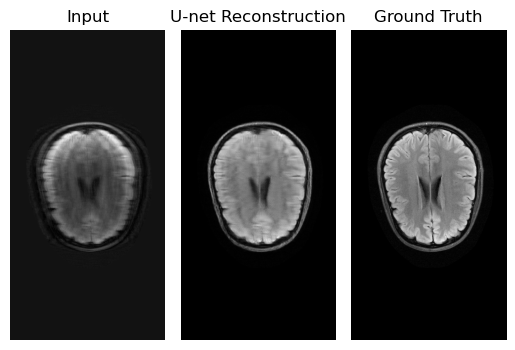

In [7]:
input_image_plot = complex_abs(torch.moveaxis(((input_image - mean)/std) , 1, -1 )).squeeze(0).squeeze(0).cpu().detach().numpy()

fig, axes = plt.subplots(1, 3)

axes[0].imshow(input_image_plot,cmap='gray')
axes[0].set_title('Input')
axes[0].axis('off')

axes[1].imshow(output_image_1c.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[1].set_title('U-net Reconstruction')
axes[1].axis('off')

axes[2].imshow(ground_truth_image.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[2].set_title('Ground Truth')
axes[2].axis('off')

plt.subplots_adjust(wspace=0.1)
plt.show()

### Inference with test-time training

In [5]:
TTT_EPOCH = 200
model = model_self
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
l1_loss = torch.nn.L1Loss(reduction='sum')
train_inputs = input_image.to(device)
input_kspace = input_kspace.to(device)
input_mask = input_mask.to(device)
sens_maps = sens_maps.to(device)
std = std.to(device)
mean = mean.to(device)

for iteration in range(TTT_EPOCH):
    train_outputs = model(train_inputs)
    train_outputs = train_outputs * std + mean
    train_outputs = torch.moveaxis(train_outputs, 1, -1 )
    sens_maps = sens_maps.to(device)
    output_sens_image = complex_mul(train_outputs, sens_maps)
    Fimg = fft2c(output_sens_image)
    Fimg_forward = Fimg * input_mask
    loss_self = l1_loss(Fimg_forward, input_kspace) / torch.sum(torch.abs(input_kspace))

    optimizer.zero_grad()
    loss_self.backward()
    optimizer.step()

In [19]:
l1_loss, nmse_loss, psnr_loss, ssim_loss, output_image, output_image_1c = evaluate2c_imagepair(model, input_image, target_image, mean, std, ground_truth_image)
print('L1_loss: ', l1_loss)
print('NMSE: ', nmse_loss)
print('PSNR: ', psnr_loss)
print('SSIM: ', ssim_loss)

Inference time:  0.008770942687988281
L1_loss:  0.11420031636953354
NMSE:  0.009852834977209568
PSNR:  34.355926513671875
SSIM:  0.9270870685577393


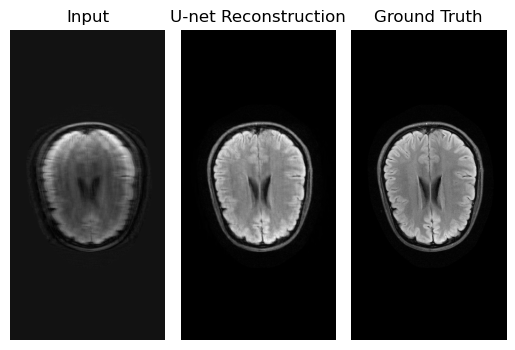

In [21]:
input_image = input_image.to(device)
input_image_plot = complex_abs(torch.moveaxis(((input_image - mean)/std) , 1, -1 )).squeeze(0).squeeze(0).cpu().detach().numpy()

fig, axes = plt.subplots(1, 3)

axes[0].imshow(input_image_plot,cmap='gray')
axes[0].set_title('Input')
axes[0].axis('off')

axes[1].imshow(output_image_1c.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[1].set_title('U-net Reconstruction')
axes[1].axis('off')

axes[2].imshow(ground_truth_image.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[2].set_title('Ground Truth')
axes[2].axis('off')

plt.subplots_adjust(wspace=0.1)
plt.show()

Plot

In [7]:
ssim_fct = SSIMLoss()

train_inputs = input_image.to(device)
train_targets = target_image.to(device)
input_kspace = input_kspace.to(device)
input_mask = input_mask.to(device)
sens_maps = sens_maps.to(device)
std = std.to(device)
mean = mean.to(device)
ground_truth_image = ground_truth_image.to(device)
binary_background_mask = binary_background_mask.to(device)

def TTT(model, TTT_epoch, adapt_lr): 
    optimizer = torch.optim.Adam(model.parameters(),lr=adapt_lr)
    l1_loss = torch.nn.L1Loss(reduction='sum')
    loss_l1_history = []
    loss_ssim_history = []
    self_loss_history = []

    for iteration in range(TTT_epoch):
        # fθ(A†y)
        train_outputs = model(train_inputs)
        train_outputs = train_outputs * std + mean
        # supervised loss [x, fθ(A†y)]
        # L1
        loss_l1 = (l1_loss(train_outputs, train_targets) / torch.sum(torch.abs(train_targets))).item()
        #print('Test L1 loss: ',loss_l1)
        loss_l1_history.append(loss_l1)
        # SSIM = 1 - loss
        output_image_1c = complex_abs(torch.moveaxis(train_outputs , 1, -1 ))
        loss_ssim = 1 - ssim_fct(output_image_1c, ground_truth_image, data_range = ground_truth_image.max().unsqueeze(0)).item()
        #print('Test SSIM loss: ',loss_ssim)
        loss_ssim_history.append(loss_ssim)

        # self-supervised loss
        # fθ(A†y)
        train_outputs = torch.moveaxis(train_outputs, 1, -1 )
        # S fθ(A†y)
        output_sens_image = complex_mul(train_outputs, sens_maps)
        # FS fθ(A†y)
        Fimg = fft2c(output_sens_image)
        # MFS fθ(A†y) = A fθ(A†y)
        Fimg_forward = Fimg * input_mask
        # self-supervised loss [y, Afθ(A†y)]
        loss_self = l1_loss(Fimg_forward, input_kspace) / torch.sum(torch.abs(input_kspace))

        optimizer.zero_grad()
        loss_self.backward()
        optimizer.step()
        #train_loss += loss.item()
        #print('TTT loss: ',loss_self.item())
        self_loss_history.append(loss_self.item())

    return loss_l1_history, loss_ssim_history, self_loss_history

In [12]:
checkpoint_path_meta1 = '/cheng/metaMRI/metaMRI/save/E11.4_maml(l1_CA-1e-3-4_P)_T300_150epoch/E11.4_maml(l1_CA-1e-3-4_P)_T300_150epoch_E79_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11/E11.2_maml(L1-5adapt)_T300_200epoch/E11.2_maml(L1-5adapt)_T300_200epoch_E116_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11.3_maml(l1_CA-1e-3-4_P)_T300_200epoch/E11.3_maml(l1_CA-1e-3-4_P)_T300_200epoch_E79_best.pth'


model_meta1 = Unet(in_chans=2, out_chans=2, chans=32, num_pool_layers=4, drop_prob=0.0)
model_meta1.load_state_dict(torch.load(checkpoint_path_meta1))
model_meta1 = model_meta1.to(device)

checkpoint_path_meta2 = '/cheng/metaMRI/metaMRI/save/E11/E11.2_maml(L1-5adapt)_T300_200epoch/E11.2_maml(L1-5adapt)_T300_200epoch_E116_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11/E11.2_maml(L1-5adapt)_T300_200epoch/E11.2_maml(L1-5adapt)_T300_200epoch_E116_best.pth'
# '/cheng/metaMRI/metaMRI/save/E11.3_maml(l1_CA-1e-3-4_P)_T300_200epoch/E11.3_maml(l1_CA-1e-3-4_P)_T300_200epoch_E79_best.pth'


model_meta2 = Unet(in_chans=2, out_chans=2, chans=32, num_pool_layers=4, drop_prob=0.0)
model_meta2.load_state_dict(torch.load(checkpoint_path_meta2))
model_meta2 = model_meta2.to(device)

In [13]:
meta_loss_l1_history1, meta_loss_ssim_history1, meta_self_loss_history1 = TTT(model_meta1, TTT_epoch=1000, adapt_lr=0.0001)
meta_min_index1 = np.argmin(meta_loss_l1_history1)
print('Meta-TTT E11.4 best epoch: ',meta_min_index1)

meta_loss_l1_history2, meta_loss_ssim_history2, meta_self_loss_history2 = TTT(model_meta2, TTT_epoch=1000, adapt_lr=0.0001)
meta_min_index2 = np.argmin(meta_loss_l1_history2)
print('Meta-TTT E11.2 best epoch: ',meta_min_index2)

Meta-TTT E11.4 best epoch:  201
Meta-TTT E11.2 best epoch:  300


MAML 5 adapt step: inner self, outer joint

In [8]:
loss_l1_history, loss_ssim_history, self_loss_history = TTT(model_self, TTT_epoch=1000, adapt_lr=0.0001)
min_index = np.argmin(loss_l1_history)
print('TTT best epoch: ',min_index)

meta_loss_l1_history, meta_loss_ssim_history, meta_self_loss_history = TTT(model_meta, TTT_epoch=1000, adapt_lr=0.0001)
meta_min_index = np.argmin(meta_loss_l1_history)
print('Meta-TTT best epoch: ',meta_min_index)

TTT best epoch:  234
Meta-TTT best epoch:  201


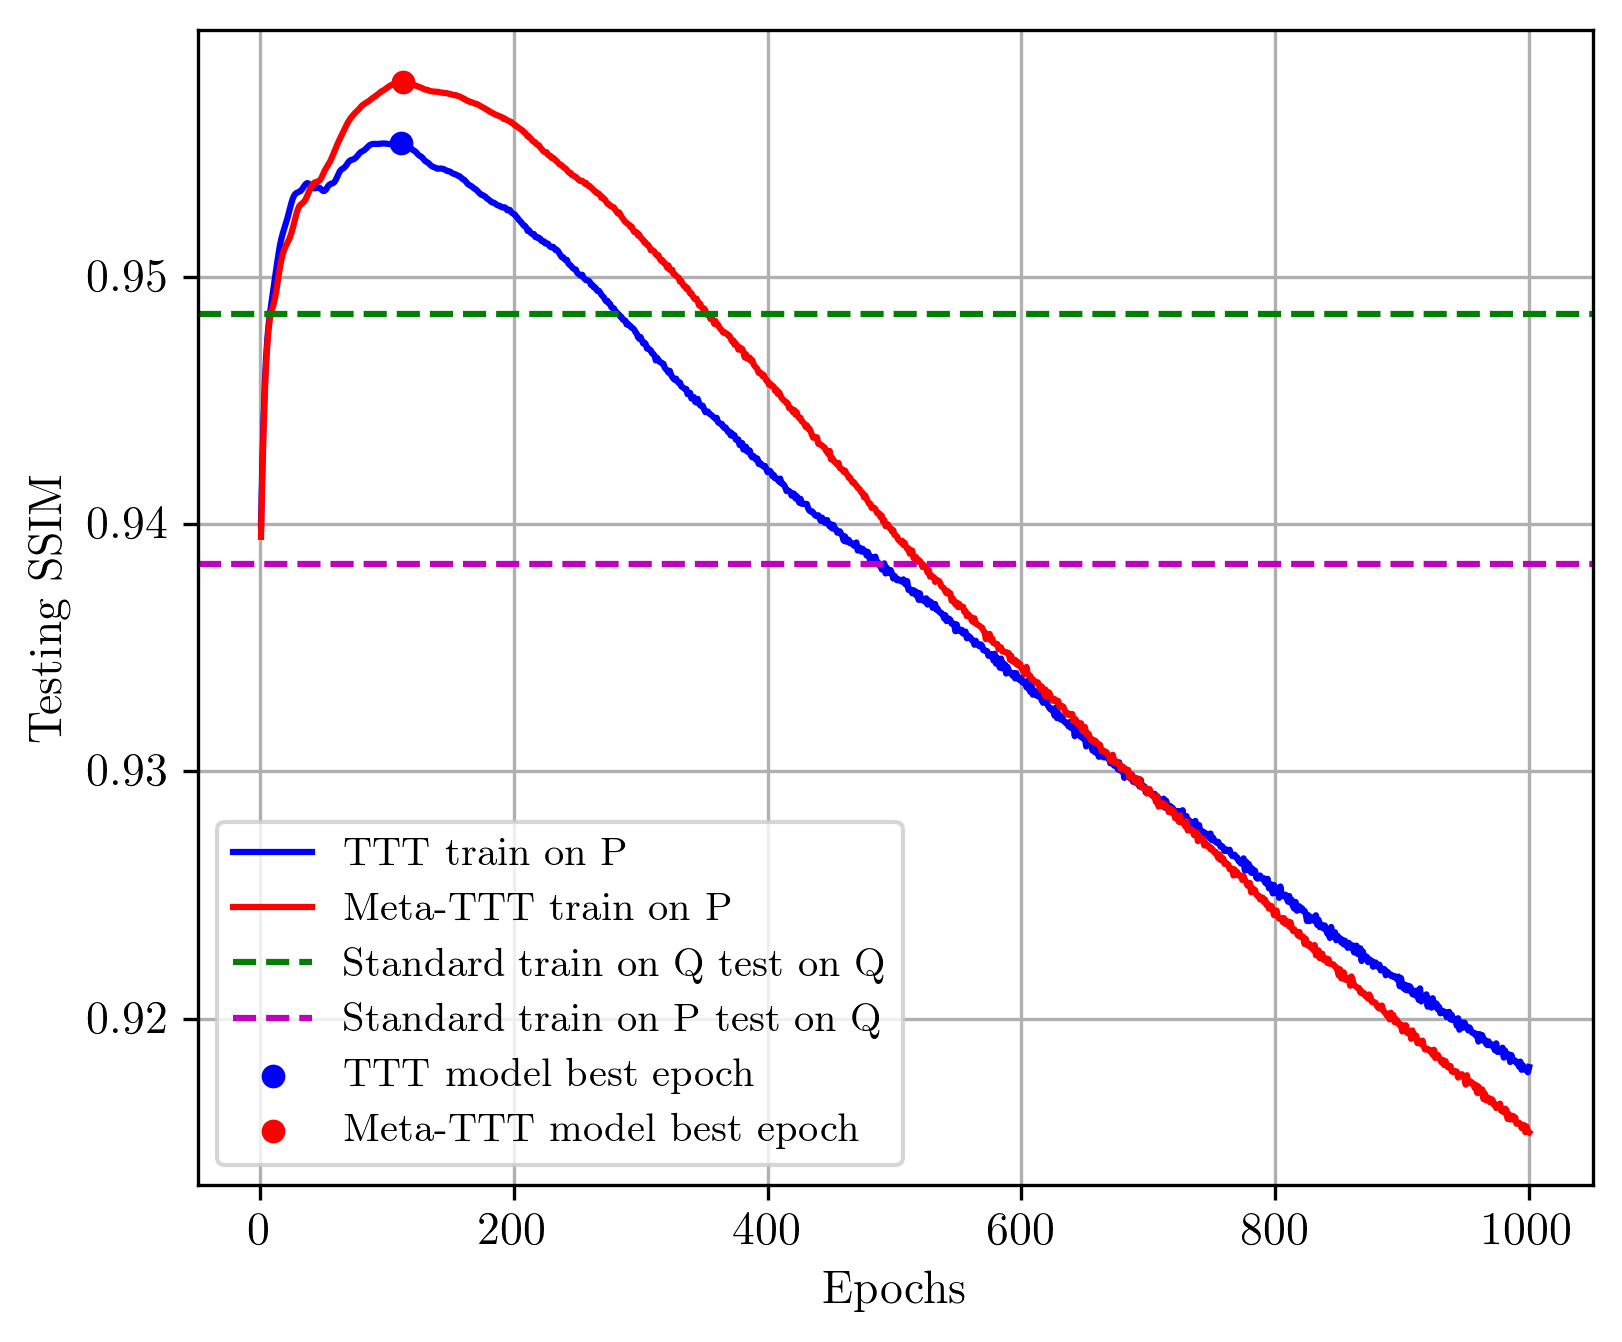

In [9]:
TTT_EPOCH = 1000
upper_bound = 0.9485
lower_bound = 0.9384

max_index2 = np.argmax(meta_loss_ssim_history)
max_index1 = np.argmax(loss_ssim_history)

plt.figure(figsize=(6,5),dpi=300)
plt.grid(True, zorder=1)    # grid on bottom
# alpha: transparency 
plt.plot(range(1, TTT_EPOCH+1), loss_ssim_history, color=colors[0], label='TTT train on P')
plt.plot(range(1, TTT_EPOCH+1), meta_loss_ssim_history, color=colors[1], label='Meta-TTT train on P ')

plt.axhline(y = upper_bound, color=colors[3], linestyle='--', label='Standard train on Q test on Q ')   # upper bound
# plt.text(x=850, y=upper_bound+0.005, s='upper bound', color=colors[2])
plt.axhline(y = lower_bound, color=colors[4], linestyle='--', label='Standard train on P test on Q ')   # upper bound

plt.scatter(max_index1, loss_ssim_history[max_index1], color=colors[0], s=FONTSIZE, label = 'TTT model best epoch', zorder=2)
plt.scatter(max_index2, meta_loss_ssim_history[max_index2], color=colors[1], s=FONTSIZE, label = 'Meta-TTT model best epoch', zorder=2)

plt.tick_params(axis='both', which='major', labelsize=FONTSIZE/2)
plt.tick_params(axis='both', which='minor', labelsize=(FONTSIZE-2)/2)
plt.xlabel('Epochs',fontsize=FONTSIZE/2)
plt.ylabel('Testing SSIM',fontsize=FONTSIZE/2)
#plt.title('Out-of-distribution Q3 Adaptation', fontsize = FONTSIZE/2)
plt.legend(fontsize = (FONTSIZE-3)/2)

plt.show()

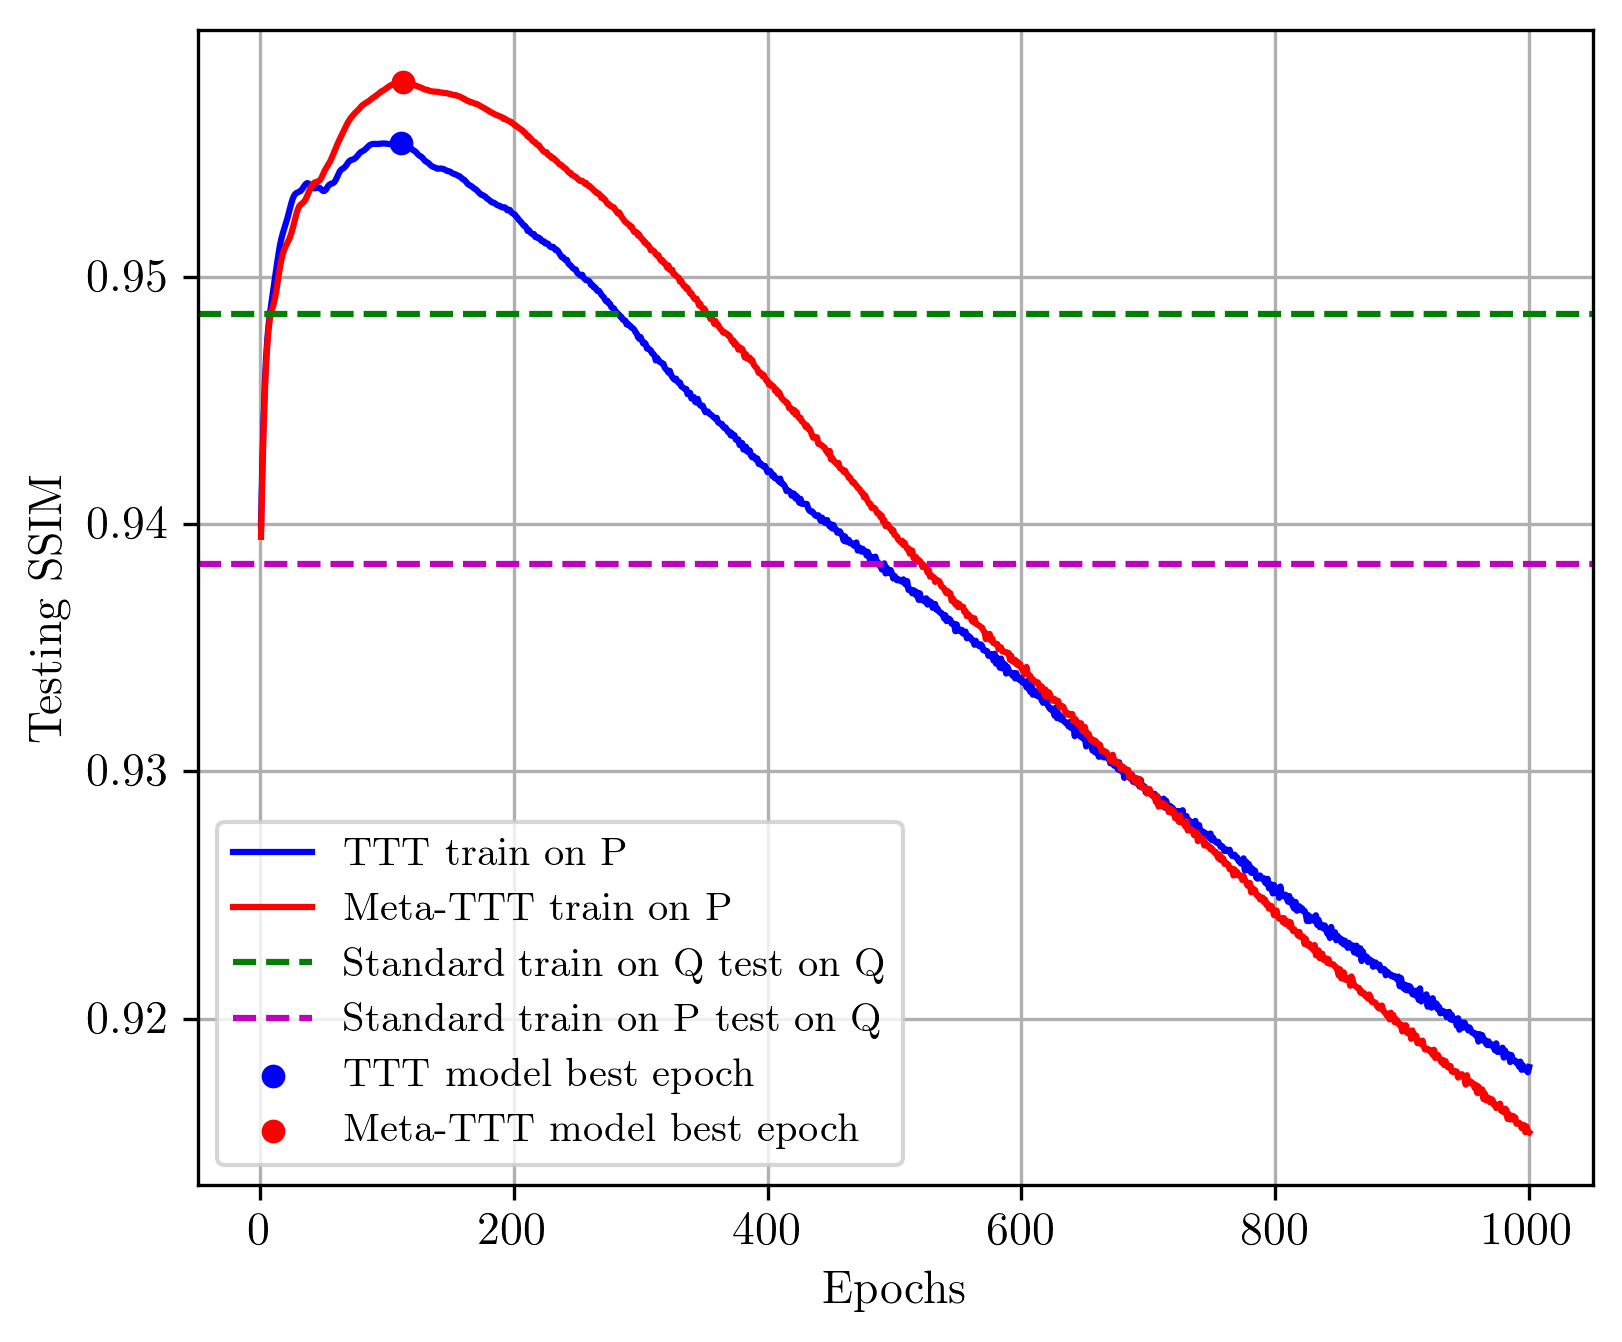

In [11]:
TTT_EPOCH = 1000
upper_bound = 0.9485
lower_bound = 0.9384

max_index2 = np.argmax(meta_loss_ssim_history)
max_index1 = np.argmax(loss_ssim_history)

plt.figure(figsize=(6,5),dpi=300)
plt.grid(True, zorder=1)    # grid on bottom
# alpha: transparency 
plt.plot(range(1, TTT_EPOCH+1), loss_ssim_history, color=colors[0], label='TTT train on P')
plt.plot(range(1, TTT_EPOCH+1), meta_loss_ssim_history, color=colors[1], label='Meta-TTT train on P ')

plt.axhline(y = upper_bound, color=colors[3], linestyle='--', label='Standard train on Q test on Q ')   # upper bound
# plt.text(x=850, y=upper_bound+0.005, s='upper bound', color=colors[2])
plt.axhline(y = lower_bound, color=colors[4], linestyle='--', label='Standard train on P test on Q ')   # upper bound

plt.scatter(max_index1, loss_ssim_history[max_index1], color=colors[0], s=FONTSIZE, label = 'TTT model best epoch', zorder=2)
plt.scatter(max_index2, meta_loss_ssim_history[max_index2], color=colors[1], s=FONTSIZE, label = 'Meta-TTT model best epoch', zorder=2)

plt.tick_params(axis='both', which='major', labelsize=FONTSIZE/2)
plt.tick_params(axis='both', which='minor', labelsize=(FONTSIZE-2)/2)
plt.xlabel('Epochs',fontsize=FONTSIZE/2)
plt.ylabel('Testing SSIM',fontsize=FONTSIZE/2)
#plt.title('Out-of-distribution Q3 Adaptation', fontsize = FONTSIZE/2)
plt.legend(fontsize = (FONTSIZE-3)/2)

plt.show()

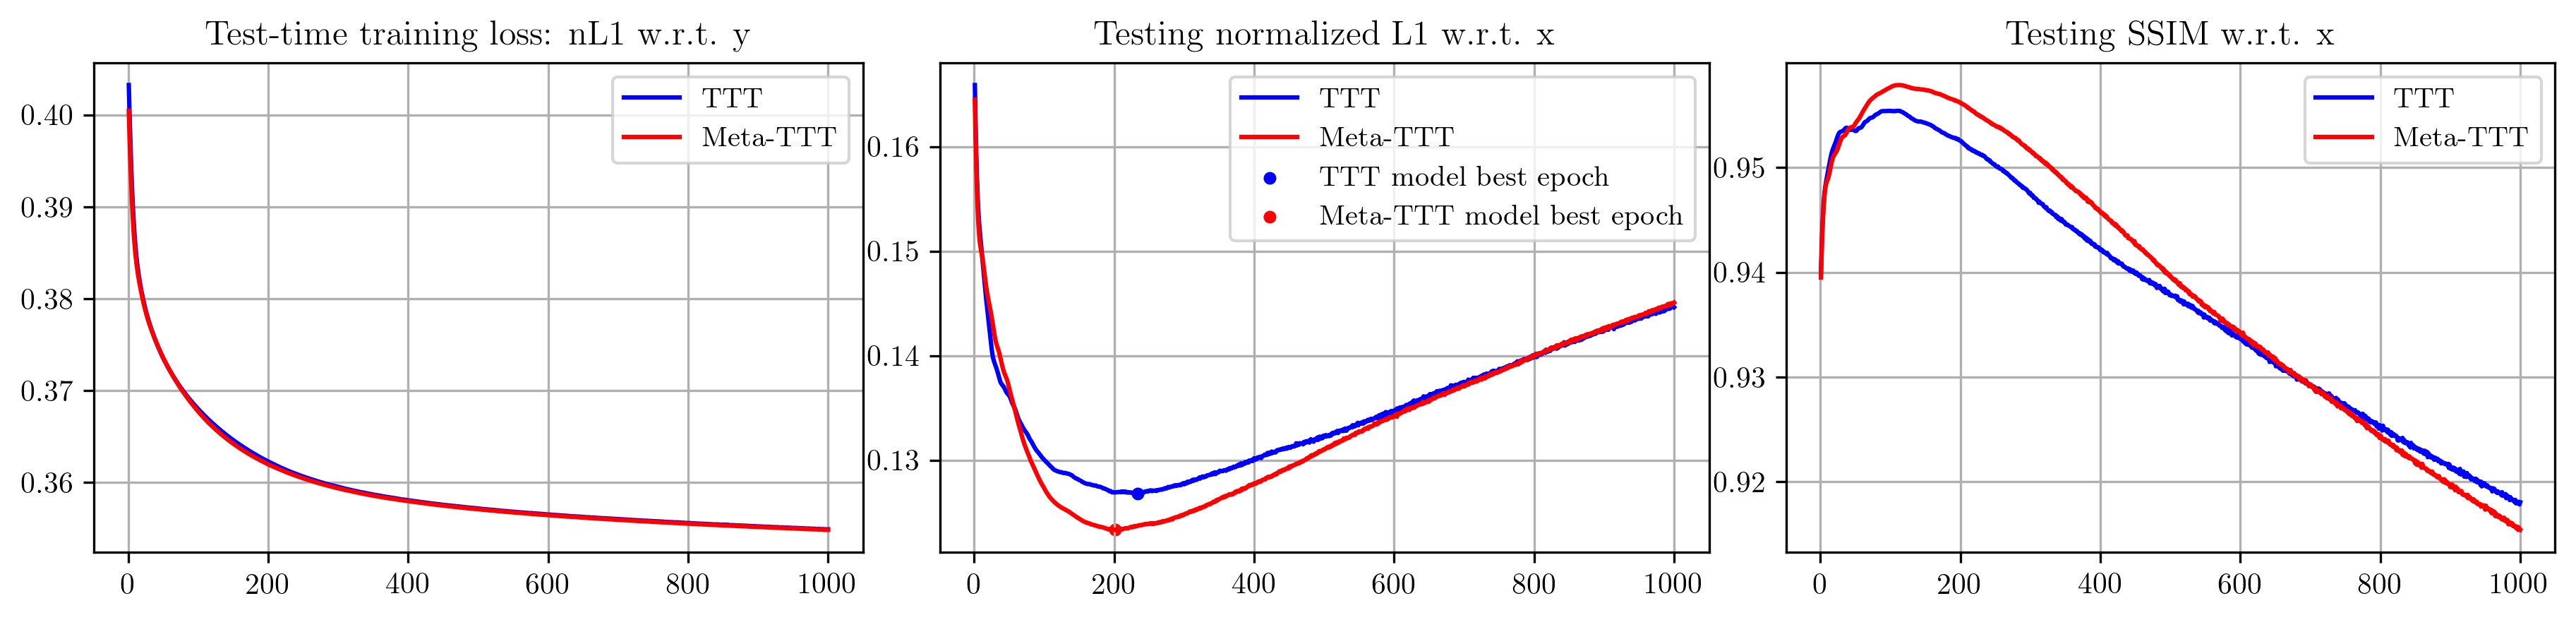

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15,3), dpi=300)
axes[0].plot(range(1, TTT_EPOCH+1), self_loss_history, color=colors[0], label='TTT')
axes[0].plot(range(1, TTT_EPOCH+1), meta_self_loss_history, color=colors[1], label='Meta-TTT')
axes[0].set_title('Test-time training loss: nL1 w.r.t. y')
axes[0].legend(fontsize = (FONTSIZE-3)/2)
axes[0].grid(True)

axes[1].plot(range(1, TTT_EPOCH+1), loss_l1_history, color=colors[0], label='TTT')
axes[1].plot(range(1, TTT_EPOCH+1), meta_loss_l1_history, color=colors[1], label='Meta-TTT')
axes[1].scatter(min_index, loss_l1_history[min_index], color=colors[0], s=FONTSIZE/2, label = 'TTT model best epoch')
axes[1].scatter(meta_min_index, meta_loss_l1_history[meta_min_index], color=colors[1], s=FONTSIZE/2, label = 'Meta-TTT model best epoch')
axes[1].set_title('Testing normalized L1 w.r.t. x')
# axes[1].set_ylim(0.10, 0.20)
axes[1].legend(fontsize = (FONTSIZE-3)/2)
axes[1].grid(True)

axes[2].plot(range(1, TTT_EPOCH+1), loss_ssim_history, color=colors[0], label='TTT')
axes[2].plot(range(1, TTT_EPOCH+1), meta_loss_ssim_history, color=colors[1], label='Meta-TTT')
axes[2].set_title('Testing SSIM w.r.t. x')
# axes[2].set_ylim(0.83, 0.94)
axes[2].legend(fontsize = (FONTSIZE-3)/2)
axes[2].grid(True)

plt.subplots_adjust(wspace=0.1)
#plt.legend(fontsize = (FONTSIZE-3)/2)
plt.show()

Meta self-supervised training best epoch:  79


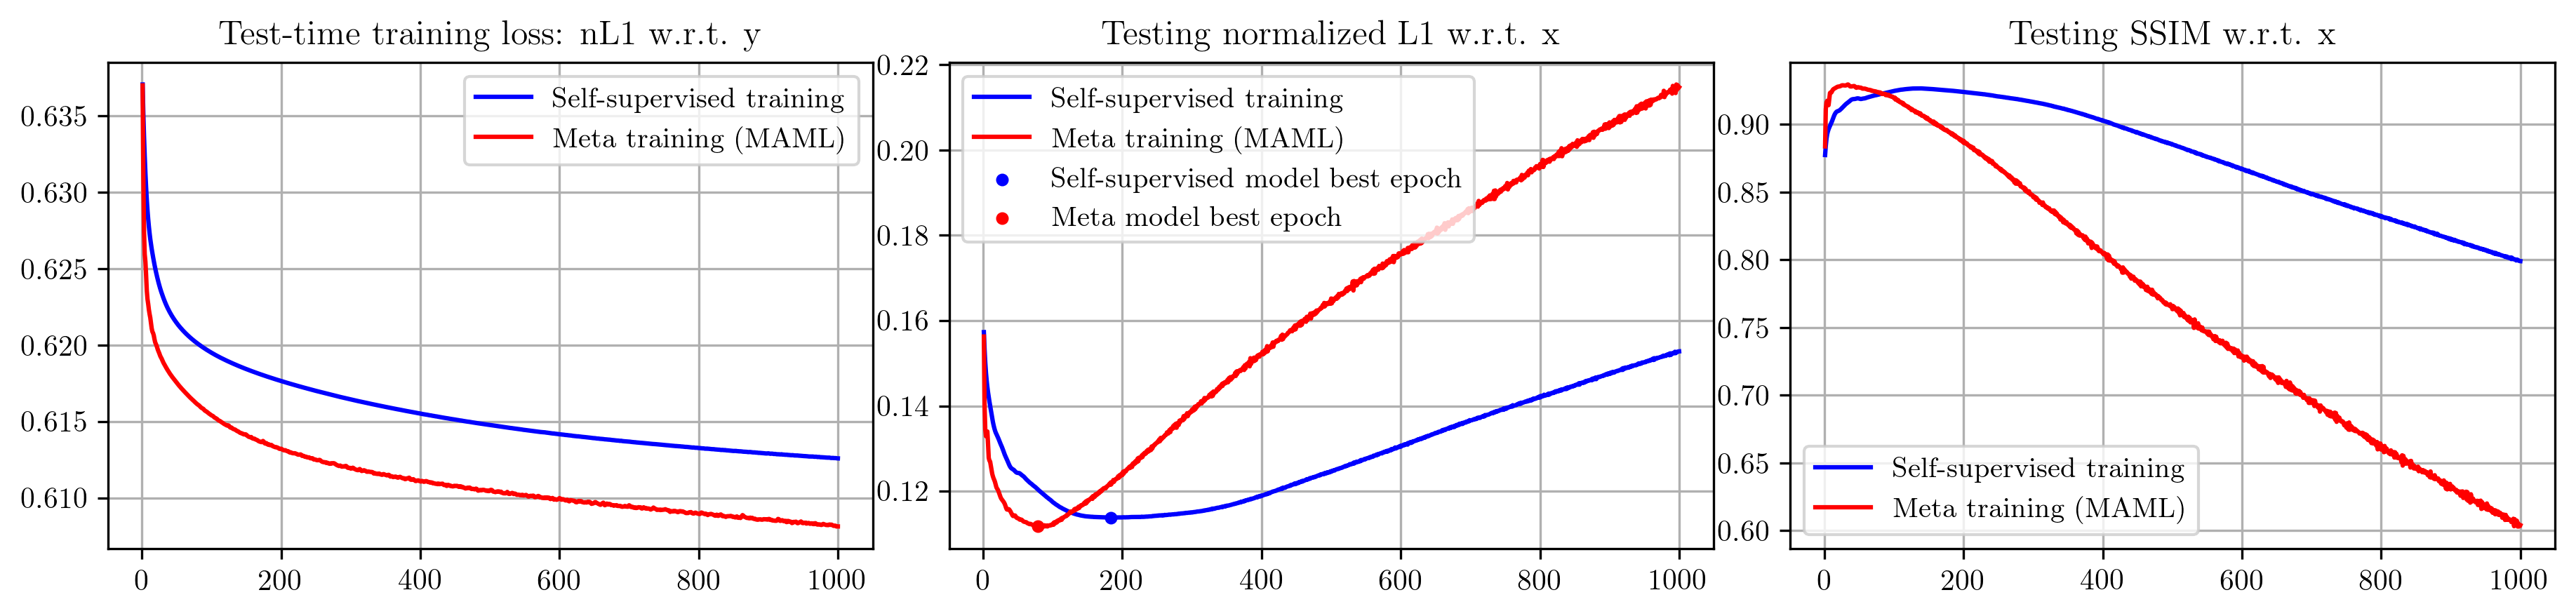

In [15]:
meta_loss_l1_history, meta_loss_ssim_history, meta_self_loss_history = TTT(model_meta, TTT_EPOCH, adapt_lr=0.001)
meta_min_index = np.argmin(meta_loss_l1_history)
print('Meta self-supervised training best epoch: ',meta_min_index)

fig, axes = plt.subplots(1, 3, figsize=(15,3), dpi=300)
axes[0].plot(range(1, TTT_EPOCH+1), self_loss_history, color=colors[0], label='Self-supervised training')
axes[0].plot(range(1, TTT_EPOCH+1), meta_self_loss_history, color=colors[1], label='Meta training (MAML)')
axes[0].set_title('Test-time training loss: nL1 w.r.t. y')
axes[0].legend(fontsize = (FONTSIZE-3)/2)
axes[0].grid(True)

axes[1].plot(range(1, TTT_EPOCH+1), loss_l1_history, color=colors[0], label='Self-supervised training')
axes[1].plot(range(1, TTT_EPOCH+1), meta_loss_l1_history, color=colors[1], label='Meta training (MAML)')
axes[1].scatter(min_index, loss_l1_history[min_index], color=colors[0], s=FONTSIZE/2, label = 'Self-supervised model best epoch')
axes[1].scatter(meta_min_index, meta_loss_l1_history[meta_min_index], color=colors[1], s=FONTSIZE/2, label = 'Meta model best epoch')
axes[1].set_title('Testing normalized L1 w.r.t. x')
# axes[1].set_ylim(0.10, 0.20)
axes[1].legend(fontsize = (FONTSIZE-3)/2)
axes[1].grid(True)

axes[2].plot(range(1, TTT_EPOCH+1), loss_ssim_history, color=colors[0], label='Self-supervised training')
axes[2].plot(range(1, TTT_EPOCH+1), meta_loss_ssim_history, color=colors[1], label='Meta training (MAML)')
axes[2].set_title('Testing SSIM w.r.t. x')
# axes[2].set_ylim(0.83, 0.94)
axes[2].legend(fontsize = (FONTSIZE-3)/2)
axes[2].grid(True)

plt.subplots_adjust(wspace=0.1)
#plt.legend(fontsize = (FONTSIZE-3)/2)
plt.show()

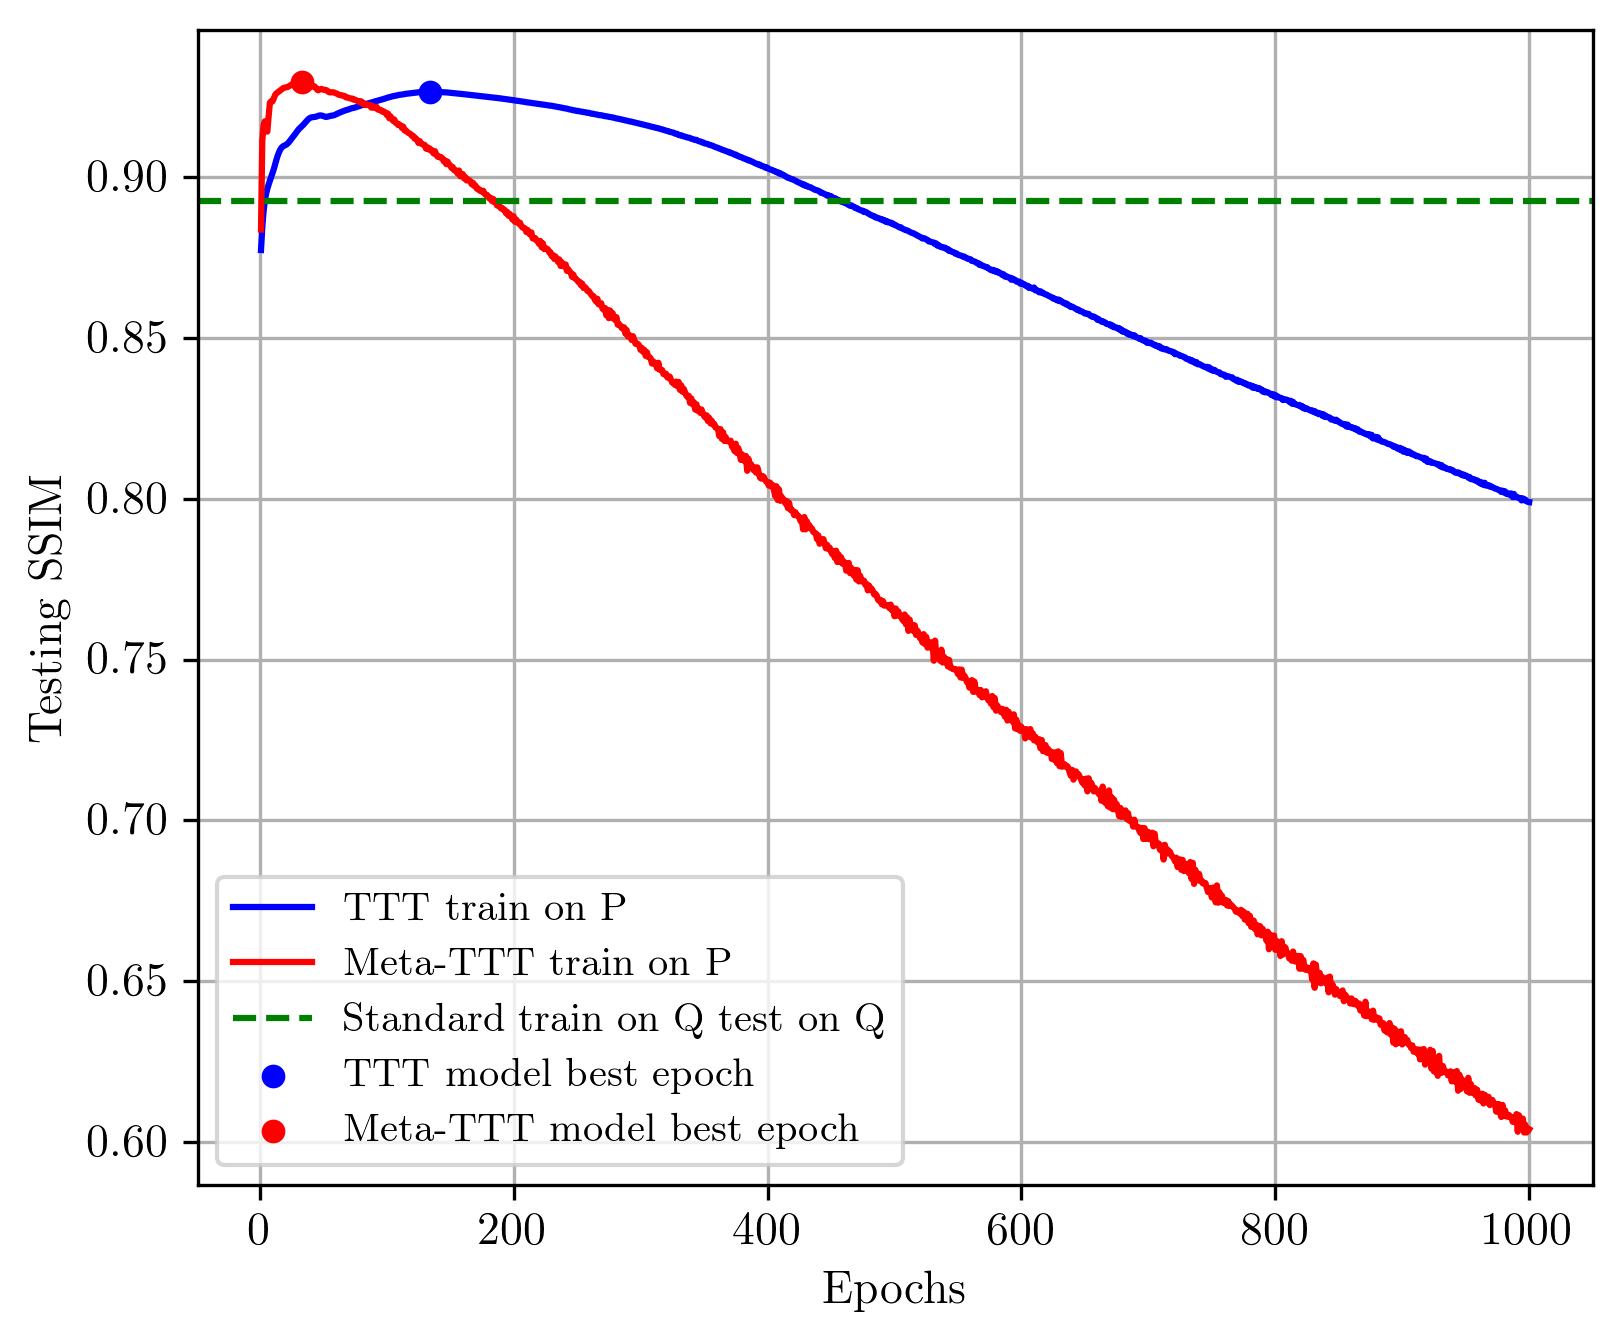

In [30]:
upper_bound = 0.8926

max_index2 = np.argmax(meta_loss_ssim_history)
max_index1 = np.argmax(loss_ssim_history)

plt.figure(figsize=(6,5),dpi=300)
plt.grid(True, zorder=1)    # grid on bottom
# alpha: transparency 
plt.plot(range(1, TTT_EPOCH+1), loss_ssim_history, color=colors[0], label='TTT train on P')
plt.plot(range(1, TTT_EPOCH+1), meta_loss_ssim_history, color=colors[1], label='Meta-TTT train on P ')

plt.axhline(y = upper_bound, color=colors[3], linestyle='--', label='Standard train on Q test on Q ')   # upper bound
# plt.text(x=850, y=upper_bound+0.005, s='upper bound', color=colors[2])

plt.scatter(max_index1, loss_ssim_history[max_index1], color=colors[0], s=FONTSIZE, label = 'TTT model best epoch', zorder=2)
plt.scatter(max_index2, meta_loss_ssim_history[max_index2], color=colors[1], s=FONTSIZE, label = 'Meta-TTT model best epoch', zorder=2)

plt.tick_params(axis='both', which='major', labelsize=FONTSIZE/2)
plt.tick_params(axis='both', which='minor', labelsize=(FONTSIZE-2)/2)
plt.xlabel('Epochs',fontsize=FONTSIZE/2)
plt.ylabel('Testing SSIM',fontsize=FONTSIZE/2)
#plt.title('Out-of-distribution Q3 Adaptation', fontsize = FONTSIZE/2)
plt.legend(fontsize = (FONTSIZE-3)/2)

plt.show()